## 2 Binding Models
Showing how laws can be modeled in bellini

Current unresolved issues: 
- Inference fails when using LogNormals as the initial distribution in pre-equilibrium solution. Why?
- Sometimes inference leads to high-variance predictions in `amount_ligand` and `amount_protein`. Is this due to TruncatedNormals or a bug in bellini?

### 2a: Simple Two Component Binding Model
Below we model a simple protein-ligand binding system, similar to that described in [assaytools](https://assaytools.readthedocs.io/en/latest/theory.html#two-component-binding-model)

#### i) Inference using complex concentration

In [1]:
import bellini
from bellini.quantity import Quantity as Q
from bellini.units import ureg
import networkx as nx
import numpy as np

For a two-compnent binding system like this, we have analytical solutions to the equilibrium concentrations. Let's compute some synthetic data to test on:

In [2]:
# We define a Kd,
Kd = Q(2e-9, ureg.mole / ureg.liter) # M

# a protein concentration,
Ptot = Q(1e-9 * np.ones([12],np.float64), ureg.mole / ureg.liter) # M

# and a gradient of ligand concentrations for our experiment.
Ltot = Q(20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]), ureg.mole / ureg.liter) # M

# We know errors from our pipetting instruments.
P_error = 0.35
L_error = 0.08
# so here's are some uncertainty hyperparams for the noise in the actual concentrations
dPstated = P_error * Ptot
dLstated = L_error * Ltot

def two_component_binding(Kd, Ptot, Ltot):
    """
    Parameters
    ----------
    Kd : float
        Dissociation constant
    Ptot : float
        Total protein concentration
    Ltot : float
        Total ligand concentration
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    PL : float
        Complex concentration
    """
                                    
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)  
    
    return [P, L, PL]

# synthetic expected outputs
[P, L, PL] = two_component_binding(Kd, Ptot, Ltot)
[P, L, PL]

[array([9.99950003e-14, 3.16177758e-13, 9.99499751e-13, 3.15726982e-12,
        9.94975623e-12, 3.11154893e-11, 9.48100502e-11, 2.63569721e-10,
        5.61552813e-10, 8.16631005e-10, 9.36229150e-10, 9.79212349e-10]) <Unit('mole / liter')>,
 array([1.99990001e-05, 6.32355564e-06, 1.99900100e-06, 6.31458689e-07,
        1.99009950e-07, 6.22766687e-08, 1.90948101e-08, 5.58812504e-09,
        1.56155281e-09, 4.49086537e-10, 1.36229150e-10, 4.24579022e-11]) <Unit('mole / liter')>,
 array([9.99900005e-10, 9.99683822e-10, 9.99000500e-10, 9.96842730e-10,
        9.90050244e-10, 9.68884511e-10, 9.05189950e-10, 7.36430279e-10,
        4.38447187e-10, 1.83368995e-10, 6.37708504e-11, 2.07876510e-11]) <Unit('mole / liter')>]

And here's a binding curve for some visualization

/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


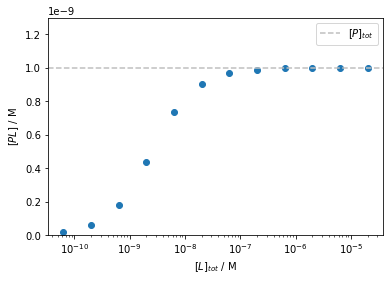

In [3]:
import matplotlib.pyplot as plt
# [L]_tot vs [PL]

# y will be complex concentration
# x will be total ligand concentration
plt.semilogx(Ltot,PL, 'o')
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$[PL]$ / M')
plt.ylim(0,1.3e-9)
plt.axhline(Ptot[0].magnitude,color='0.75',linestyle='--',label='$[P]_{tot}$')
plt.legend()

Let's create a solution containing both protein and ligand pre-equilibration

In [4]:
from bellini.distributions import Normal, gen_lognorm, TruncatedNormal
from bellini.groups import Species, Solution
protein = Species('protein')
ligand = Species('ligand')
water = Species('water')

# we're converting these to moles since that makes making the solution a little easier
Ptot_moles = Ptot.to_units(ureg.mole, force=True)
Ltot_moles = Ltot.to_units(ureg.mole, force=True)
dPstated_moles = dPstated.to_units(ureg.mole, force=True)
dLstated_moles = dLstated.to_units(ureg.mole, force=True)

amount_protein = TruncatedNormal(Q(0, ureg.mole), Ptot_moles, dPstated_moles)
amount_ligand = TruncatedNormal(Q(0, ureg.mole), Ltot_moles, dLstated_moles)
amount_protein.name = "amount_protein"
amount_ligand.name = "amount_ligand"

pre_eq_sol = Solution(
    mixture = (
        amount_protein * protein + 
        amount_ligand * ligand
    ),
    solvent = water * Q(1, ureg.liter)
)

We now want to apply our equilibrium model to this solution. To do this we'll create a `Law` object, which acts as a wrapper for applying some physical law (in the form of a function) on a `Group` e.g. a Solution.

To make some of the later operations easier, we also introduce an object called a `Reference`, or `Ref` for short. This is basically a pointer that also stores subindexes, which allows for general indexing across bellini. In particular, functions that `Law`s wrap must return dictionaries keyed by `Reference`s. 

In [5]:
import jax.numpy as jnp
from bellini.reference import Reference as Ref

# our Ref for the concentrations of various species in a Solution
conc_ref = Ref("concentrations")

# the function our Law implements
def equilibrium_concentrations(DeltaG, Ptot, Ltot):
        """
        Compute equilibrium concentrations for simple two-component association.

        Parameters
        ----------
        DeltaG : float
           Reduced free energy of binding (in units of kT)
        Ptot : float or numpy array
           Total protein concentration summed over bound and unbound species, molarity.
        Ltot : float or numpy array
           Total ligand concentration summed over bound and unbound speciesl, molarity.

        Returns
        -------
        P : float or numpy array with same dimensions as Ptot
           Free protein concentration, molarity.
        L : float or numpy array with same dimensions as Ptot
           Free ligand concentration, molarity.
        PL : float or numpy array with same dimensions as Ptot
           Bound complex concentration, molarity.

        """
        MOLAR = ureg.mole / ureg.liter
        Ptot = Ptot.to_units(MOLAR).magnitude
        Ltot = Ltot.to_units(MOLAR).magnitude
        DeltaG = DeltaG.magnitude
        # Handle only strictly positive elements---all others are set to zero as constants
        try:
            nonzero_indices = jnp.where(Ltot > 0)[0]
            zero_indices = jnp.where(Ltot <= 0)[0]
        except:
            nonzero_indices = jnp.array(range(Ltot.shape[0]))
            zero_indices = jnp.array([])
        nnonzero = len(nonzero_indices)
        nzeros = len(zero_indices)

        # Numerically stable variant
        dtype = jnp.float32
        Ptot = Ptot.astype(dtype)  # promote to dtype
        Ltot = Ltot.astype(dtype)  # promote to dtype
        PL = jnp.zeros(Ptot.shape, dtype)
        logP = jnp.log(jnp.take(Ptot, nonzero_indices))
        #print("logP", logP)
        logL = jnp.log(jnp.take(Ltot, nonzero_indices))
        #print("logL", logL)
        logPLK = jnp.logaddexp(jnp.logaddexp(logP, logL), DeltaG)
        #print("logPLK", logPLK)
        PLK = jnp.exp(logPLK)
        #print("PLK", PLK)
        sqrt_arg = 1.0 - jnp.exp(jnp.log(4.0) + logP + logL - 2.0 * logPLK)
        sqrt_arg = jnp.where(sqrt_arg >= 0.0, sqrt_arg, 0)  # ensure always positive
        #print("sqrt_arg", sqrt_arg)
        PL = PL.at[nonzero_indices].set(
            0.5 * PLK * (1.0 - jnp.sqrt(sqrt_arg))
        )  # complex concentration (M)
        #print("PL", PL)

        # Compute remaining concentrations.
        P = Ptot - PL
        # free protein concentration in sample cell after n injections (M)
        L = Ltot - PL
        # free ligand concentration in sample cell after n injections (M)

        # Ensure all concentrations are within limits, correcting cases where numerical issues cause problems.
        PL = jnp.where(PL >= 0.0, PL, 0.0)  # complex cannot have negative concentration
        P = jnp.where(P >= 0.0, P, 0.0)
        L = jnp.where(L >= 0.0, L, 0.0)
        
        PL = Q(PL, MOLAR)
        P = Q(P, MOLAR)
        L = Q(L, MOLAR)

        return {
            conc_ref["P"]: P,
            conc_ref["L"]: L,
            conc_ref["PL"]: PL
        }

One of our unknown parameters in the `Law` is the binding free energy. We'll place a uniform prior over this

In [6]:
from bellini.distributions import Uniform

DG_min = Q(np.log(1e-15), ureg.kcal / ureg.mole)  # kT
DG_max = Q(0.0, ureg.kcal / ureg.mole) # kT

dG = Uniform(DG_min, DG_max)
dG.name = "dG"

In [7]:
from bellini.laws import Law

# our two componenet binding law
twocomplaw = Law(
    fn=equilibrium_concentrations,
    input_mapping={
        "Ptot": conc_ref[protein],
        "Ltot": conc_ref[ligand],
    },
    output_labels=[
        conc_ref[label] for label in ("P", "L", "PL")
    ],
    params={
        "DeltaG": dG
    },
    name="twocompeq"
)

We can now apply this law to our solution and measure the predicted complex concentration using our magic concentration measuring device:

In [8]:
from bellini.containers import Container
eq_sol = twocomplaw(pre_eq_sol)
eq_vial = Container(eq_sol)

from bellini.devices import Measurer
conc_measure = Measurer("magic_measurer", var=Q(1e-11, ureg.mole / ureg.liter))
infer_pl = conc_measure.readout(eq_vial, value=conc_ref['PL'])
infer_pl

N(_JTDist: equilibrium_concentrations for concentrations[PL] [mole / liter], 9.999999999999999×10⁻²³ mol ** 2 / l ** 2)[mole / liter]

As usual, we also can make a nx graph showing the computation graph the model implements.

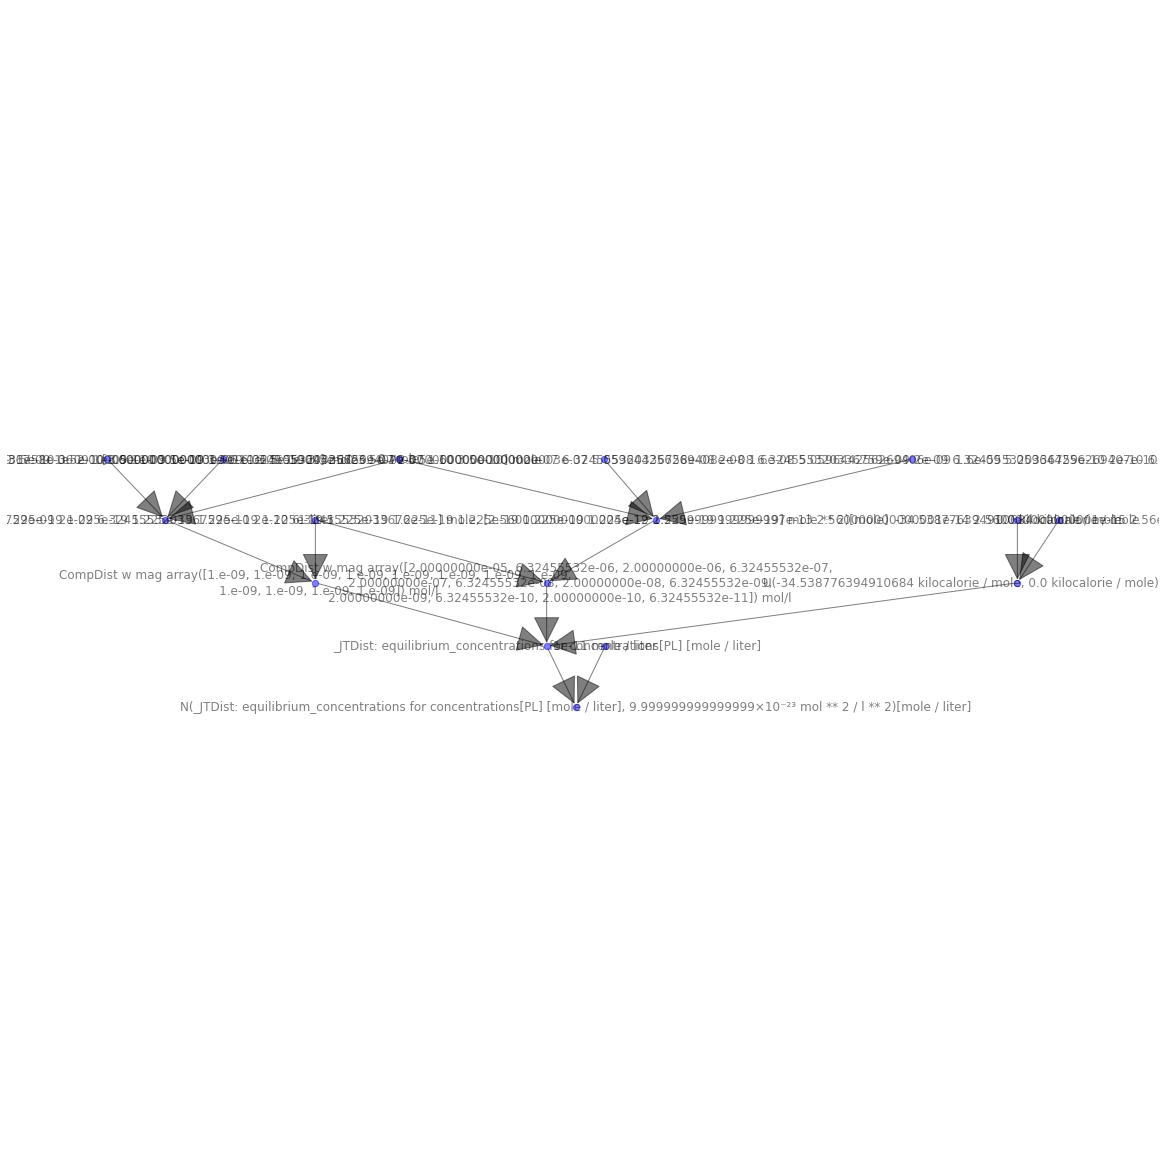

In [9]:
import matplotlib.pyplot as plt
import networkx as nx

# This example needs Graphviz and either PyGraphviz or pydot
# from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import graphviz_layout

G = infer_pl.g

pos = graphviz_layout(G, prog='dot', args='-Granksep=6') #nx.drawing.layout.spiral_layout(G)
plt.figure(figsize=(16, 16))
nx.draw(G, pos, node_size=40, alpha=0.5, node_color="blue", with_labels=True, arrowsize=60)
#nx.draw_networkx_labels(G,pos,labels, font_color='r', font_size='30')
plt.axis("equal")
plt.show()

Let's use MCMC to predict dG. We'll use the helper class below:

In [10]:
import numpy as np
import numpyro
import numpyro.distributions as dist
import arviz as az
import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt

niter = 500000  # number of iterations
nburn = 50000  # number of burn-in iterations to discard
nthin = 500  # thinning interval

class MCMCModel:
    def __init__(
        self,
        model,
        kernel_args={'step_size':1},
        mcmc_args={"num_warmup": nburn, "num_samples": niter, "thinning": nthin},
    ):
        self.model = model
        self.mcmc = None
        self.kernel_args = kernel_args
        self.mcmc_args = mcmc_args
        self.params = None
        rng_key = random.PRNGKey(0)  # TODO: make option to choose random seed
        self.rng_key_infer, self.rng_key_predict = random.split(rng_key)

    def run_mcmc(self, *args, **kwargs):
        nuts_kernel = NUTS(self.model, **self.kernel_args)
        self.mcmc = MCMC(nuts_kernel, **self.mcmc_args)
        self.mcmc.run(self.rng_key_infer, *args, **kwargs)
        self.sample_params()

    def sample_params(self):
        self.params = self.mcmc.get_samples()

    def predict(self, *args, **kwargs):
        predictor = Predictive(self.model, self.params)
        return predictor(self.rng_key_predict, *args, **kwargs)

    def plot_results(self, exclude_deterministic=False):
        self.mcmc.print_summary(exclude_deterministic=exclude_deterministic)
        data = az.from_numpyro(self.mcmc)
        az.plot_trace(data)

And now, we'll perform inference, conditioning on the true (synthetic) complex concentration and plotting the results

In [11]:
from bellini.api._numpyro import graph_to_numpyro_model
import numpyro 

model = graph_to_numpyro_model(infer_pl.g)
mcmc_wrapper = MCMCModel(model, mcmc_args={"num_warmup": 10000, "num_samples": 20000, "thinning": 1})
mcmc_wrapper.run_mcmc(obs={infer_pl: PL})

sample: 100%|██████████| 30000/30000 [00:32<00:00, 911.51it/s, 31 steps of size 8.81e-02. acc. prob=0.94] 



                        mean       std    median      5.0%     95.0%     n_eff     r_hat
  amount_ligand[0]      0.00      0.00      0.00      0.00      0.00  26423.97      1.00
  amount_ligand[1]      0.00      0.00      0.00      0.00      0.00  25728.59      1.00
  amount_ligand[2]      0.00      0.00      0.00      0.00      0.00  26027.82      1.00
  amount_ligand[3]      0.00      0.00      0.00      0.00      0.00  26203.90      1.00
  amount_ligand[4]      0.00      0.00      0.00      0.00      0.00  24731.87      1.00
  amount_ligand[5]      0.00      0.00      0.00      0.00      0.00  23834.86      1.00
  amount_ligand[6]      0.00      0.00      0.00      0.00      0.00  24218.56      1.00
  amount_ligand[7]      0.00      0.00      0.00      0.00      0.00  21335.59      1.00
  amount_ligand[8]      0.00      0.00      0.00      0.00      0.00  22158.24      1.00
  amount_ligand[9]      0.00      0.00      0.00      0.00      0.00  22519.10      1.00
 amount_ligand[10]  

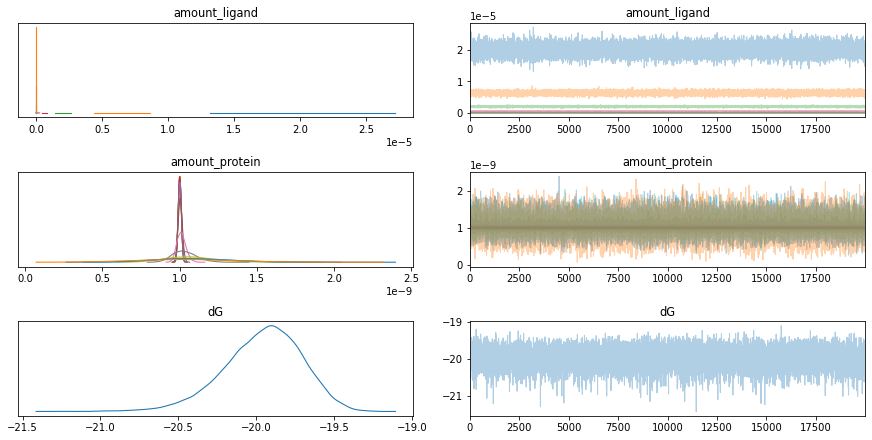

In [12]:
mcmc_wrapper.plot_results(exclude_deterministic=False)

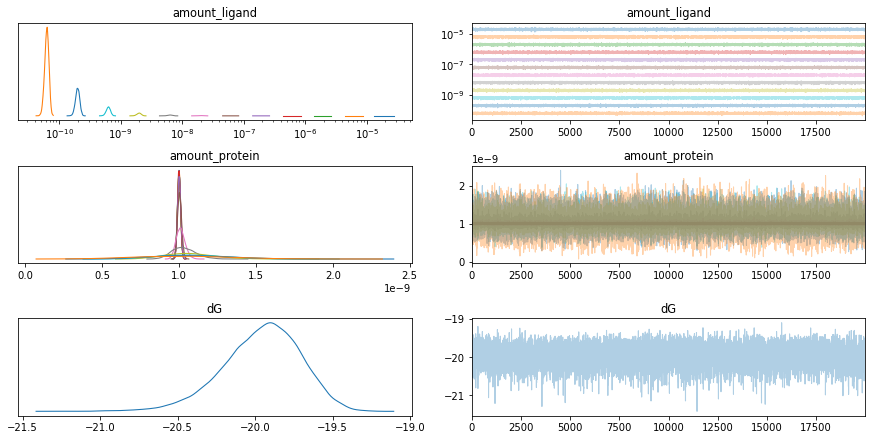

In [13]:
# we also plot amount_ligand on log scale to see that the concentration difference is consistent
data = az.from_numpyro(mcmc_wrapper.mcmc)
ax = az.plot_trace(data)
ax[0][0].set_xscale('log')
ax[0][1].set_yscale('log')

For the most part, results are pretty good.

We can also build predictive models using the MCMC model to see how well the model and data match:

/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/bellini-0+untagged.111.g978617d.dirty-py3.9.egg/bellini/api/_numpyro.py:51: UserWarning: observed node magic_measurer_Well containing CompDist w mag array([1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09]) mol/l of protein and CompDist w mag array([2.00000000e-05, 6.32455532e-06, 2.00000000e-06, 6.32455532e-07,
       2.00000000e-07, 6.32455532e-08, 2.00000000e-08, 6.32455532e-09,
       2.00000000e-09, 6.32455532e-10, 2.00000000e-10, 6.32455532e-11]) mol/l of ligand in 1 liter of water_concentrations[PL]_0 was not given data to condition on. no conditioning performed.
/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/numpy/core/_asarray

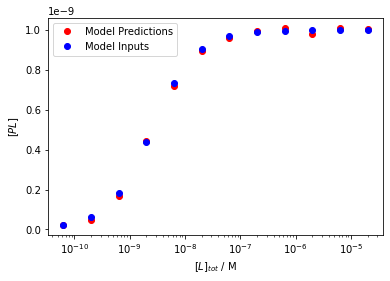

In [14]:
# plot the model's predictions on the original data to see how closely it matches
predictions = mcmc_wrapper.predict()
plt.semilogx(Ltot, list(predictions.items())[-1][1][0], 'ro', label="Model Predictions")
plt.semilogx(Ltot,PL, 'bo', label="Model Inputs")
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$[PL]$')
plt.legend()

#### ii) Inference using fluorscence based on complex alone

Let's try a simple fluorescence experiment, where only the complex fluorescence (e.g. a FRET experiment)

In [15]:
# Making max 1400 relative fluorescence units, and scaling all of PL (complex concentration) 
# to that, adding some random noise
npoints = len(Ltot)
sigma = 10.0 # size of noise

#Let's add an F_background 
#F_background = 40
# make some simplifying assumptions without fluoresence of the ligand
F_PL_i = ((1400/1e-9)*PL).unitless() + sigma * np.random.randn(npoints)

We also define a fluorescence `Law` to create a measurable fluorescence, and apply this `Law` to our equilibrated solution from before.

In [16]:
fluor_ref = Ref("fluorescence")

def fluorescence(concentration, scaling_constant):
    fluor = concentration * scaling_constant * 1e9 # just adding this for easier scaling
    return {
        fluor_ref: fluor.unitless()
    }

scaling_constant = Uniform(Q(1), Q(2000))
scaling_constant.name = "fluorescence_scaling_factor"
fluor_law = Law(
    fn=fluorescence,
    input_mapping={
        "concentration": conc_ref["PL"],
    },
    output_labels=[fluor_ref],
    params={
        "scaling_constant": scaling_constant,
    }
)

In [17]:
fluor_sol = fluor_law(eq_sol)
fluor_vial = Container(fluor_sol)

fluor_measure = Measurer("fluor_measure", var=Q(10))
infer_f = fluor_measure.readout(fluor_vial, value="fluorescence")
infer_f

N(_JTDist: fluorescence for fluorescence [dimensionless], 100.00)[dimensionless]

Now we perform inference, conditioning on our synthetic fluorescence output.

In [18]:
from bellini.api._numpyro import graph_to_numpyro_model
import numpyro 

model = graph_to_numpyro_model(infer_f.g)
mcmc_wrapper = MCMCModel(model, mcmc_args={"num_warmup": 100000, "num_samples": 20000, "thinning": 1})
mcmc_wrapper.run_mcmc(obs={infer_f: F_PL_i})

sample: 100%|██████████| 120000/120000 [02:54<00:00, 687.15it/s, 255 steps of size 1.46e-02. acc. prob=0.94]



                                   mean       std    median      5.0%     95.0%     n_eff     r_hat
             amount_ligand[0]      0.00      0.00      0.00      0.00      0.00  29730.33      1.00
             amount_ligand[1]      0.00      0.00      0.00      0.00      0.00  29501.62      1.00
             amount_ligand[2]      0.00      0.00      0.00      0.00      0.00  28988.45      1.00
             amount_ligand[3]      0.00      0.00      0.00      0.00      0.00  29241.67      1.00
             amount_ligand[4]      0.00      0.00      0.00      0.00      0.00  29940.25      1.00
             amount_ligand[5]      0.00      0.00      0.00      0.00      0.00  28035.74      1.00
             amount_ligand[6]      0.00      0.00      0.00      0.00      0.00  28126.39      1.00
             amount_ligand[7]      0.00      0.00      0.00      0.00      0.00  25462.86      1.00
             amount_ligand[8]      0.00      0.00      0.00      0.00      0.00  24572.74      1.00

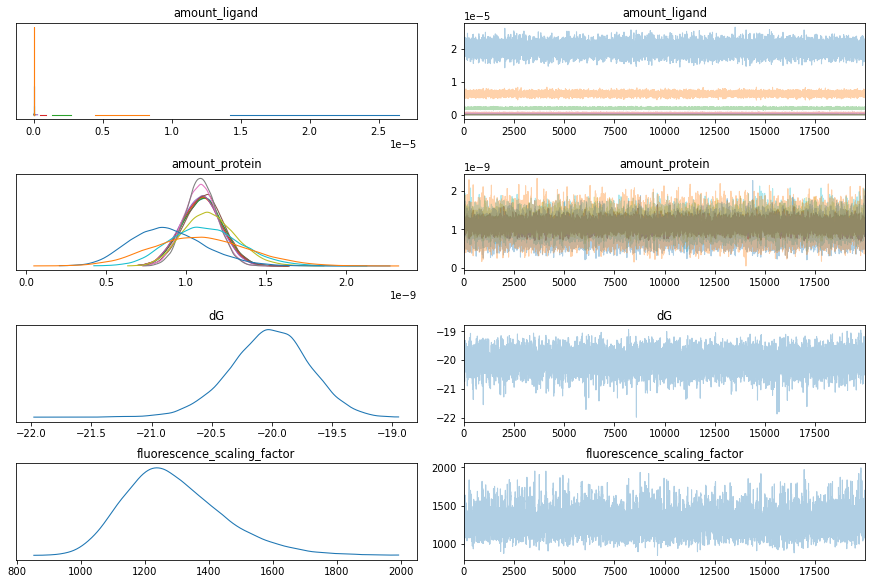

In [19]:
mcmc_wrapper.plot_results(exclude_deterministic=False)

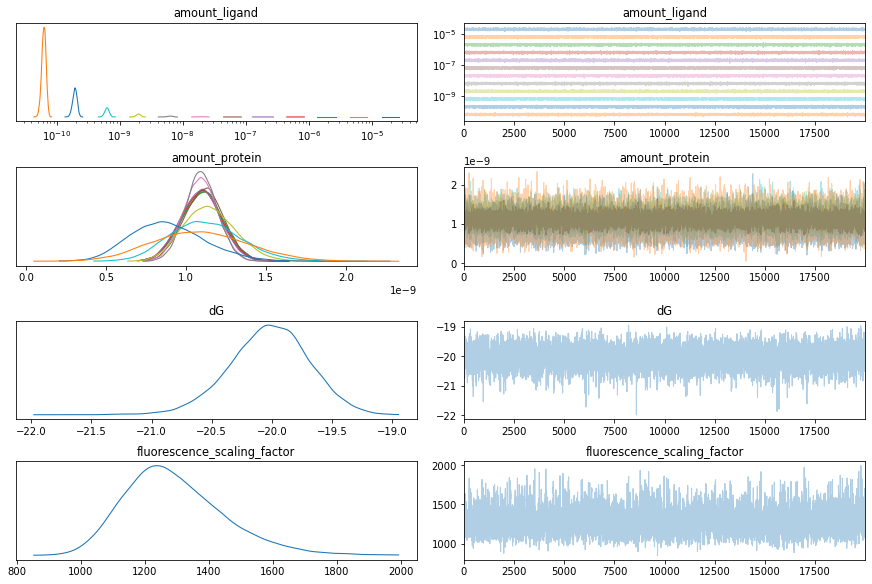

In [20]:
# we also plot amount_ligand on log scale to see that the concentration difference is consistent
data = az.from_numpyro(mcmc_wrapper.mcmc)
ax = az.plot_trace(data)
ax[0][0].set_xscale('log')
ax[0][1].set_yscale('log')

Again, we build predictive models using the MCMC model to see how well the model and data match:

/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/bellini-0+untagged.111.g978617d.dirty-py3.9.egg/bellini/api/_numpyro.py:51: UserWarning: observed node fluor_measure_Well containing CompDist w mag array([1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09]) mol/l of protein and CompDist w mag array([2.00000000e-05, 6.32455532e-06, 2.00000000e-06, 6.32455532e-07,
       2.00000000e-07, 6.32455532e-08, 2.00000000e-08, 6.32455532e-09,
       2.00000000e-09, 6.32455532e-10, 2.00000000e-10, 6.32455532e-11]) mol/l of ligand in 1 liter of water_fluorescence_0 was not given data to condition on. no conditioning performed.
/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/numpy/core/_asarray.py:102

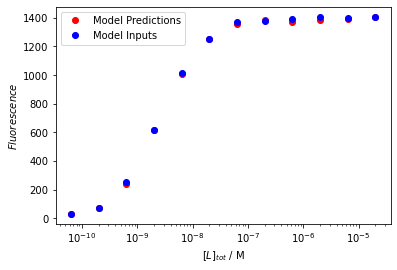

In [21]:
# plot the model's predictions on the original data to see how closely it matches
predictions = mcmc_wrapper.predict()
plt.semilogx(Ltot, list(predictions.items())[-1][1][0], 'ro', label="Model Predictions")
plt.semilogx(Ltot,F_PL_i, 'bo', label="Model Inputs")
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend()

#### iii) Inference using fluorescence based on both ligand and complex

What about if we want to account for the fluorescence of the ligand too? Let's model a more complex fluorescence `Law`.

In [22]:
#Let's also add ligand fluroscence to our complex fluorescence readout
F_PL_i = ((1400/1e-9)*PL.unitless() + sigma * np.random.randn(npoints)) + ((.4/1e-8)*L.unitless() + sigma * np.random.randn(npoints))

# and make a more complex fluorescence Law as well
def fluorescence(concentration_1, scaling_constant_1, concentration_2, scaling_constant_2):
    fluor = concentration_1 * scaling_constant_1 * 1e9 + concentration_2 * scaling_constant_2 * 1e7 # adding the same scaling factor for easier inference
    return {
        fluor_ref: fluor.unitless()
    }

scaling_constant_1 = Uniform(Q(1), Q(2000))
scaling_constant_1.name = "scaling_constant_PL"
scaling_constant_2 = Uniform(Q(1), Q(100))
scaling_constant_2.name = "scaling_constant_L"

fluor_law = Law(
    fn=fluorescence,
    input_mapping={
        "concentration_1": conc_ref["PL"],
        "concentration_2": conc_ref["L"],
    },
    output_labels=[fluor_ref],
    params={
        "scaling_constant_1": scaling_constant_1,
        "scaling_constant_2": scaling_constant_2
    }
)

In [23]:
# apply to original equilibrated solution as well
fluor_sol = fluor_law(eq_sol)
fluor_vial = Container(fluor_sol)

fluor_measure = Measurer("fluor_measure", var=Q(10))
infer_f = fluor_measure.readout(fluor_vial, value="fluorescence")
infer_f

N(_JTDist: fluorescence for fluorescence [dimensionless], 100.00)[dimensionless]

Now we condition the new model on our new synthetic fluorescence data:

In [25]:
model = graph_to_numpyro_model(infer_f.g)
mcmc_wrapper = MCMCModel(model, mcmc_args={"num_warmup": 100000, "num_samples": 20000, "thinning": 1})
mcmc_wrapper.run_mcmc(obs={infer_f: F_PL_i})

sample: 100%|██████████| 120000/120000 [04:43<00:00, 422.98it/s, 511 steps of size 1.23e-02. acc. prob=0.87] 



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
     amount_ligand[0]      0.00      0.00      0.00      0.00      0.00  20735.83      1.00
     amount_ligand[1]      0.00      0.00      0.00      0.00      0.00  20055.88      1.00
     amount_ligand[2]      0.00      0.00      0.00      0.00      0.00  20477.64      1.00
     amount_ligand[3]      0.00      0.00      0.00      0.00      0.00  20438.34      1.00
     amount_ligand[4]      0.00      0.00      0.00      0.00      0.00  20537.13      1.00
     amount_ligand[5]      0.00      0.00      0.00      0.00      0.00  20258.99      1.00
     amount_ligand[6]      0.00      0.00      0.00      0.00      0.00  21794.73      1.00
     amount_ligand[7]      0.00      0.00      0.00      0.00      0.00  19818.31      1.00
     amount_ligand[8]      0.00      0.00      0.00      0.00      0.00  18291.27      1.00
     amount_ligand[9]      0.00      0.00      0.00      0.00      0.00  18624.

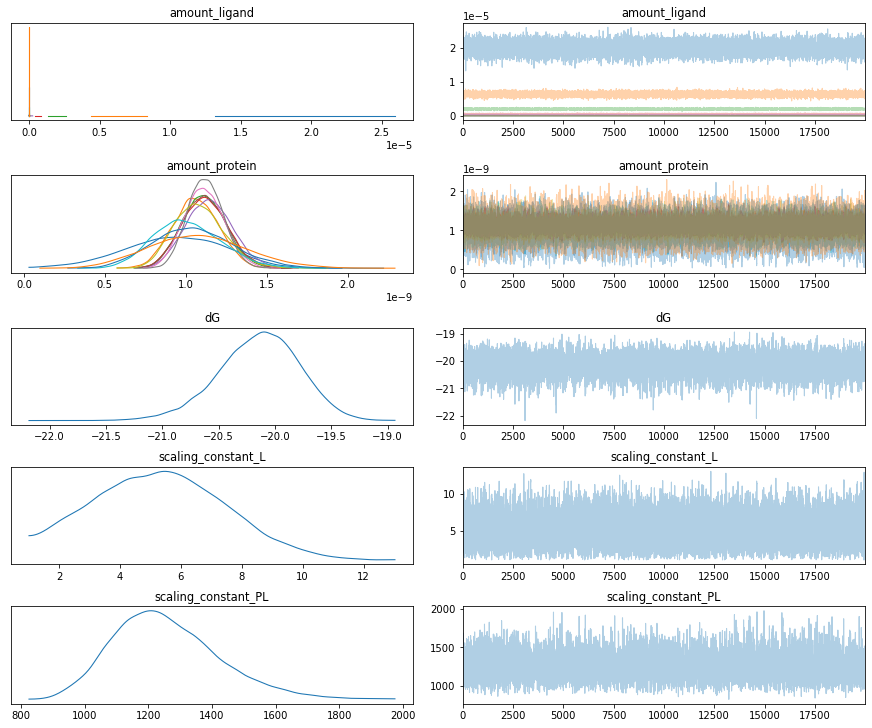

In [26]:
mcmc_wrapper.plot_results(exclude_deterministic=False)

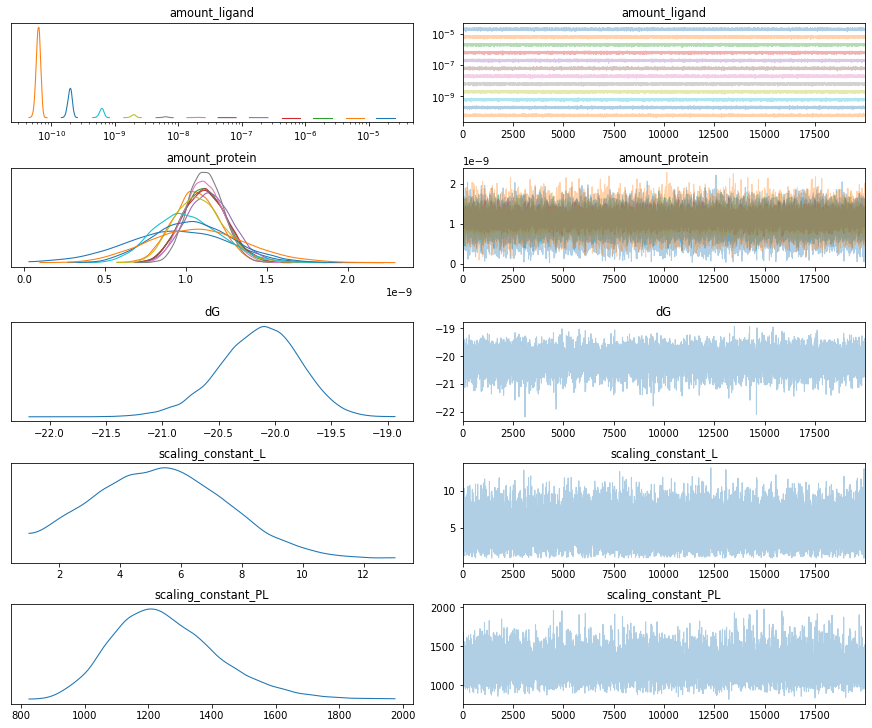

In [27]:
# we also plot amount_ligand on log scale to see that the concentration difference is consistent
data = az.from_numpyro(mcmc_wrapper.mcmc)
ax = az.plot_trace(data)
ax[0][0].set_xscale('log')
ax[0][1].set_yscale('log')

/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/bellini-0+untagged.111.g978617d.dirty-py3.9.egg/bellini/api/_numpyro.py:51: UserWarning: observed node fluor_measure_Well containing CompDist w mag array([1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09, 1.e-09,
       1.e-09, 1.e-09, 1.e-09, 1.e-09]) mol/l of protein and CompDist w mag array([2.00000000e-05, 6.32455532e-06, 2.00000000e-06, 6.32455532e-07,
       2.00000000e-07, 6.32455532e-08, 2.00000000e-08, 6.32455532e-09,
       2.00000000e-09, 6.32455532e-10, 2.00000000e-10, 6.32455532e-11]) mol/l of ligand in 1 liter of water_fluorescence_0 was not given data to condition on. no conditioning performed.
/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/home/alex/anaconda3/envs/chodera/lib/python3.9/site-packages/numpy/core/_asarray.py:102

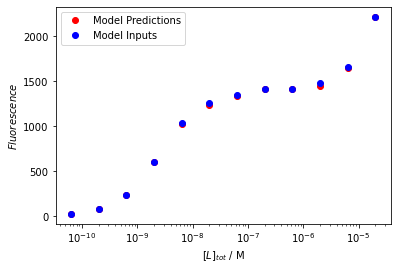

In [28]:
# plot the model's predictions on the original data to see how closely it matches
predictions = mcmc_wrapper.predict()
plt.semilogx(Ltot, list(predictions.items())[-1][1][0], 'ro', label="Model Predictions")
plt.semilogx(Ltot,F_PL_i, 'bo', label="Model Inputs")
plt.xlabel('$[L]_{tot}$ / M')
plt.ylabel('$Fluorescence$')
plt.legend()